In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!wget https://ultralytics.com/images/bus.jpg

--2025-07-27 17:02:17--  https://ultralytics.com/images/bus.jpg
Resolving ultralytics.com (ultralytics.com)... 75.2.70.75, 99.83.190.102
Connecting to ultralytics.com (ultralytics.com)|75.2.70.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ultralytics.com/images/bus.jpg [following]
--2025-07-27 17:02:17--  https://www.ultralytics.com/images/bus.jpg
Resolving www.ultralytics.com (www.ultralytics.com)... 172.64.147.154, 104.18.40.102, 2606:4700:4400::ac40:939a, ...
Connecting to www.ultralytics.com (www.ultralytics.com)|172.64.147.154|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ultralytics/assets/releases/download/v0.0.0/bus.jpg [following]
--2025-07-27 17:02:17--  https://github.com/ultralytics/assets/releases/download/v0.0.0/bus.jpg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request

In [122]:
# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Taken and modified from the original sourcde code: https://github.com/ultralytics/ultralytics/blob/main/ultralytics/models/yolo/detect/predict.py#L8

# The only modification is the addition of multi_label=True to non_max_suppression call


from ultralytics.engine.predictor import BasePredictor
from ultralytics.engine.results import Results
from ultralytics.utils import ops


class DetectionPredictor(BasePredictor):
    """
    A class extending the BasePredictor class for prediction based on a detection model.

    This predictor specializes in object detection tasks, processing model outputs into meaningful detection results
    with bounding boxes and class predictions.

    Attributes:
        args (namespace): Configuration arguments for the predictor.
        model (nn.Module): The detection model used for inference.
        batch (list): Batch of images and metadata for processing.

    Methods:
        postprocess: Process raw model predictions into detection results.
        construct_results: Build Results objects from processed predictions.
        construct_result: Create a single Result object from a prediction.
        get_obj_feats: Extract object features from the feature maps.

    Examples:
        >>> from ultralytics.utils import ASSETS
        >>> from ultralytics.models.yolo.detect import DetectionPredictor
        >>> args = dict(model="yolo11n.pt", source=ASSETS)
        >>> predictor = DetectionPredictor(overrides=args)
        >>> predictor.predict_cli()
    """

    def postprocess(self, preds, img, orig_imgs, **kwargs):
        """
        Post-process predictions and return a list of Results objects.

        This method applies non-maximum suppression to raw model predictions and prepares them for visualization and
        further analysis.

        Args:
            preds (torch.Tensor): Raw predictions from the model.
            img (torch.Tensor): Processed input image tensor in model input format.
            orig_imgs (torch.Tensor | list): Original input images before preprocessing.
            **kwargs (Any): Additional keyword arguments.

        Returns:
            (list): List of Results objects containing the post-processed predictions.

        Examples:
            >>> predictor = DetectionPredictor(overrides=dict(model="yolo11n.pt"))
            >>> results = predictor.predict("path/to/image.jpg")
            >>> processed_results = predictor.postprocess(preds, img, orig_imgs)
        """
        save_feats = getattr(self, "_feats", None) is not None
        preds = ops.non_max_suppression(
            preds,
            self.args.conf,
            self.args.iou,
            self.args.classes,
            self.args.agnostic_nms,
            max_det=self.args.max_det,
            nc=0 if self.args.task == "detect" else len(self.model.names),
            end2end=getattr(self.model, "end2end", False),
            rotated=self.args.task == "obb",
            return_idxs=save_feats,
            multi_label=True
        )

        if not isinstance(orig_imgs, list):  # input images are a torch.Tensor, not a list
            orig_imgs = ops.convert_torch2numpy_batch(orig_imgs)

        if save_feats:
            obj_feats = self.get_obj_feats(self._feats, preds[1])
            preds = preds[0]

        results = self.construct_results(preds, img, orig_imgs, **kwargs)

        if save_feats:
            for r, f in zip(results, obj_feats):
                r.feats = f  # add object features to results

        return results

    def get_obj_feats(self, feat_maps, idxs):
        """Extract object features from the feature maps."""
        import torch

        s = min([x.shape[1] for x in feat_maps])  # find smallest vector length
        obj_feats = torch.cat(
            [x.permute(0, 2, 3, 1).reshape(x.shape[0], -1, s, x.shape[1] // s).mean(dim=-1) for x in feat_maps], dim=1
        )  # mean reduce all vectors to same length
        return [feats[idx] if len(idx) else [] for feats, idx in zip(obj_feats, idxs)]  # for each img in batch

    def construct_results(self, preds, img, orig_imgs):
        """
        Construct a list of Results objects from model predictions.

        Args:
            preds (List[torch.Tensor]): List of predicted bounding boxes and scores for each image.
            img (torch.Tensor): Batch of preprocessed images used for inference.
            orig_imgs (List[np.ndarray]): List of original images before preprocessing.

        Returns:
            (List[Results]): List of Results objects containing detection information for each image.
        """
        return [
            self.construct_result(pred, img, orig_img, img_path)
            for pred, orig_img, img_path in zip(preds, orig_imgs, self.batch[0])
        ]

    def construct_result(self, pred, img, orig_img, img_path):
        """
        Construct a single Results object from one image prediction.

        Args:
            pred (torch.Tensor): Predicted boxes and scores with shape (N, 6) where N is the number of detections.
            img (torch.Tensor): Preprocessed image tensor used for inference.
            orig_img (np.ndarray): Original image before preprocessing.
            img_path (str): Path to the original image file.

        Returns:
            (Results): Results object containing the original image, image path, class names, and scaled bounding boxes.
        """
        pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], orig_img.shape)
        return Results(orig_img, path=img_path, names=self.model.names, boxes=pred[:, :6])


image 1/1 /content/bus.jpg: 640x480 77 persons, 5 bicycles, 16 cars, 1 motorcycle, 9 buss, 5 trucks, 1 traffic light, 3 fire hydrants, 1 stop sign, 1 parking meter, 4 benchs, 4 birds, 3 dogs, 40 backpacks, 1 umbrella, 82 handbags, 7 ties, 4 suitcases, 1 snowboard, 3 skateboards, 3 bottles, 1 chair, 26 potted plants, 2 cell phones, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Classes in image: ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'dog', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'snowboard', 'skateboard', 'bottle', 'chair', 'potted plant', 'cell phone']


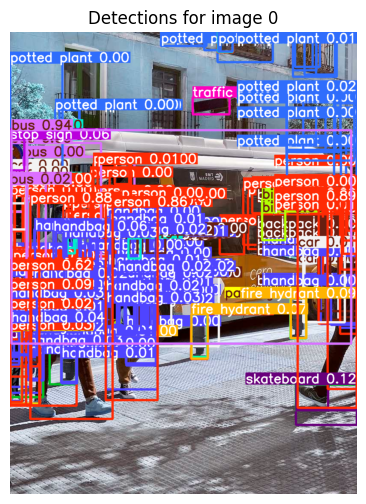

In [123]:
## CODE WITH THE CUSTOM DetectionPredict

from ultralytics import YOLO
import matplotlib.pyplot as plt

# 1. Load a pretrained YOLOv8 detection model
model = YOLO("yolo11n.pt")

# 3. Run inference on an image using your custom predictor
results = model.predict(
        source="/content/bus.jpg",
        predictor=DetectionPredictor,
        conf=0.001 # the multi label thing is much more apparent with low confidence
)

for result in results:
    classes_in_image = set(int(c) for c in result.boxes.cls)  # unique class indices
    print("Classes in image:", [model.names[c] for c in classes_in_image]) # multi_label=True in NMS will make this return more classes, compared to the multi_label=False (see the next cell, compare the class list)


# # 2. Iterate through Results and plot
for idx, res in enumerate(results):
    # res.plot() returns the image (numpy array) with boxes & labels drawn
    annotated_frame = res.plot()
    # Display with matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(annotated_frame)
    plt.axis('off')
    plt.title(f'Detections for image {idx}')
    plt.show()



image 1/1 /content/bus.jpg: 640x480 74 persons, 2 bicycles, 10 cars, 10 buss, 1 traffic light, 2 fire hydrants, 1 stop sign, 2 benchs, 4 birds, 1 dog, 17 backpacks, 1 umbrella, 78 handbags, 5 ties, 3 skateboards, 26 potted plants, 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
Classes in image: ['person', 'bicycle', 'car', 'skateboard', 'bus', 'potted plant', 'traffic light', 'fire hydrant', 'stop sign', 'bench', 'bird', 'dog', 'backpack', 'umbrella', 'handbag', 'tie']


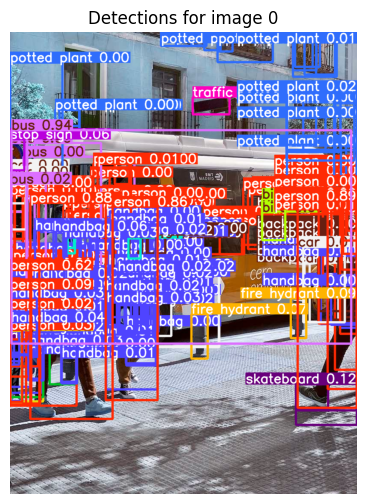

In [124]:
## CODE WITHOUT THE CUSTOM DetectionPredict
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 1. Load a pretrained YOLOv8 detection model
model = YOLO("yolo11n.pt")

results = model.predict(
        source="/content/bus.jpg",
        conf=0.001 # the multi label thing is much more apparent with low confidence
)

for result in results:
    classes_in_image = set(int(c) for c in result.boxes.cls)  # unique class indices
    print("Classes in image:", [model.names[c] for c in classes_in_image]) # multi_label=True in NMS will make this return more classes


# # 2. Iterate through Results and plot
for idx, res in enumerate(results):
    # res.plot() returns the image (numpy array) with boxes & labels drawn
    annotated_frame = res.plot()
    # Display with matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(annotated_frame)
    plt.axis('off')
    plt.title(f'Detections for image {idx}')
    plt.show()
